# Creating gymnasium environment

### Importing Packages

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import random as rd
import time

from gym import Env, spaces

### Coor class

In [56]:
class Coor():
    def __init__(self, coor):
        self.x = coor[0]
        self.y = coor[1]

    def get(self):
        return self.x, self.y
    
    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def __add__(self, coor2):
        return Coor((self.x + coor2.x, self.y + coor2.y))
    
    def __eq__(self, coor2):
        if coor2 == None:
            return False
        return (self.x==coor2.x) and (self.y==coor2.y)
    
    def __neg__(self):
        x,y = self.get()
        return Coor((-x,-y))
    
    def __sub__(self, coor2):
        coor = - coor2
        return self + coor
    
    def norm(self):
        x,y = self.get()
        return np.sqrt(x*x + y*y)
    
    def dist(self, coor2):
        return (self -coor2).norm()


### Track class

Contrary to previous environment, track are not matrix anymore.

In [151]:
RED = [255, 0, 0]
GREEN = [0, 255, 0]
BLUE = [0, 0, 255]
GREY = [70 for _ in range(3)]
WHITE = [240 for _ in range(3)]

START_CHAR = 2
END_CHAR = 3
CAR_CHAR = 4

def color(b):
    if b == START_CHAR:
        return GREEN
    elif b == END_CHAR:
        return RED
    elif b == 1:
        return GREY
    else:
        return WHITE
    

class Track():
    def __init__(self, tab):
        #switching height and width for plan approach
        self.width: int = len(tab)
        self.height: int = len((tab[0]))
        self.basic_info_track = tab
        
        self.info_track = [[None for _ in range(self.height)] for _ in range(self.width)]
        for x in range(self.width):
            for y in range(self.height):
                self.info_track[x][y] = tab[self.height-1-y][x]

        self.color_track = [[color(self.info_track[y][x]) for y in range(self.height)] for x in range(self.width)]

        self.end = None
        self.start = None
        for i in range(self.height):
            for j in range(self.width):
                if self.info_track[i][j] == START_CHAR:
                    self.start = Coor((i,j))
                if self.info_track[i][j] == END_CHAR:
                    self.end = Coor((i,j))

    def get_color(self, coor:Coor):
        """return the color of the case x,y"""
        x,y = coor.get()
        return color(self.info_track[x][y])
    
    def is_wall(self, coor:Coor):
        """Return True if case (x,y) is a wall"""
        x,y = coor.get()
        return (self.info_track[x][y] == 1)

    def get_start(self):
        """Return coordinate of start"""
        if self.start == None:
            return None
        return self.start.get()
    
    def get_end(self):
        """Return coordinate of end"""
        return self.end.get()

    def plot(self, hide=False):
        """Plot the track using matplotlib"""
        plt.imshow(self.color_track, origin='lower')
        # for x in range(self.width):
        #     for y in range(self.height):
        #         plt.text(x, y, str(x) + " " + str(y))
        plt.axis("off")
        if not hide:
            plt.show()

### Creating the track

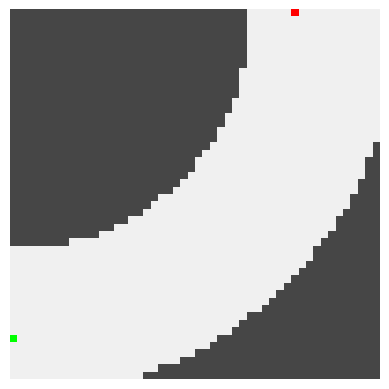

track shape: 50 50
start at coordinates: (0, 5)
end at coordinates: (38, 49)


In [154]:
def place_circle(tab, r, pos: Coor, symbol):
    height = len(tab)
    width = len(tab[0])
    for i in range(height):
        for j in range(width):
            if pos.dist(Coor((i,j))) < r:
                tab[i][j] = symbol
    return tab

N = 50
turn_1 = [[1 for _ in range(N)] for _ in range(N)]
turn_1 = place_circle(turn_1, 52, Coor((0, 0)), 0)
turn_1 = place_circle(turn_1, 32, Coor((0, 0)), 1)
turn_1[N-6][0] = START_CHAR
turn_1[0][N-12] = END_CHAR

track_1 = Track(turn_1)
track_1.plot()
print("track shape:", track_1.height, track_1.width)
print("start at coordinates:", track_1.get_start())
print("end at coordinates:", track_1.get_end())

### Car class

Car has $2$ main variable:
 - speed: $v$
 - alpha: $\alpha$ suppose to be between $0$ and $360$

To calculate the $x$-speed and $y$-speed we use the next formulas:
 - $v_x = v.cos(\alpha . \frac{\pi}{180})$
 - $v_y = v.sin(\alpha . \frac{\pi}{180})$

In [161]:
"""Constant"""


"""Class"""
class Car():
    def __init__(self, coor:Coor):
        self.coor: Coor = coor
        self.speed: float = 0
        self.alpha: float = 0 # The angle of the car according to unitary cicrle

    def __str__(self):
        return "C[" + str(self.coor) + " " + str(self.speed) + " " + str(self.alpha) + "]"

    def accelerate(self, amont=1):
        """Increase speed of the car"""
        acceleration_constant = 1
        self.speed += acceleration_constant*amont

    def brake(self, amont=1):
        """Decrease speed of the car"""
        brake_constant = 1
        self.speed -= brake_constant*amont

    def turn(self, deg):
        """Change the current rotation of the car"""
        self.alpha += deg
        self.alpha = self.alpha % 360

    def get_speed_coor(self):
        cst: float = np.pi / 180
        dx: float = self.speed * np.cos(self.alpha * cst)
        dy: float = self.speed * np.sin(self.alpha * cst)
        return Coor((dx,dy))

    def move(self):
        """Change the coordinate of the care according to its speed and alpha"""
        dx,dy = self.get_speed_coor().get()
        self.coor.x += dx
        self.coor.y += dy

    def plot(self, markersize=8, vector_constant=2):
        """Plot the car and is speed vectors"""
        # Plot car
        x,y = self.coor.get()
        plt.plot(x, y, "o", color='blue', markersize=markersize)
        plt.axis("off")

        # Plot car's directoin
        cst: float = np.pi / 180
        dx: float = np.cos(self.alpha * cst)
        dy: float = np.sin(self.alpha * cst)
        plt.arrow(x, y, dx*markersize/8, dy*markersize/8, head_width=1)
        plt.plot([x, x+ dx*self.speed*vector_constant], [y, y+ dy*self.speed*vector_constant], "-", color="red")


### Car exemple

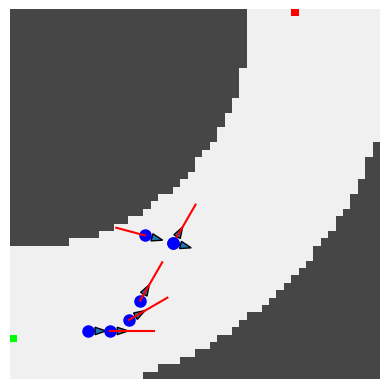

In [167]:
track_1.plot(hide=True)

car = Car(Coor((10,6)))
car.plot()

car.accelerate()
car.accelerate()
car.accelerate()
car.move()
car.plot()

car.turn(30)
car.move()
car.plot()

car.turn(30)
car.move()
car.plot()

car.move()
car.move()
car.move()
car.plot()

car.turn(-75)
car.brake()
car.brake()
car.brake()
car.plot()

car.brake()
car.brake()
car.move()
car.move()
car.plot()

plt.show()

### Gym env

In [176]:
class MyEnv(Env):
    def __init__(self, track: Track):
        super(MyEnv, self).__init__()

        # Define a 2-D observation space
        self.observation_shape = (track.height, track.width, 3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.int64)

        # Define an action space ranging from 0 to 3
        self.action_space = [i for i in range(4)]

        self.track = track
        self.car = Coor(self.track.get_start())
        # self.car_icon = cv2.imread("blue_dot.png") /255
        self.car_icon = np.array(CAR_ICON)

        self.canvas = np.array(self.track.color_track)

        self.seen = [[False for _ in range(self.track.height)] for _ in range(self.track.width)]

        self.action_meanings = {0: "Right", 1: "Left", 2: "Down", 3: "Up"}
        self.meanings_action = {"R":0, "L":1, "D":2, "U":3}
        self.moves = {0:Coor((0,1)), 1:Coor((0,-1)), 2:Coor((1,0)), 3:Coor((-1,0))}
        self.opposite_action = {0:1, 1:0, 2:3, 3:2}

    def get_opposite_action(self, action):
        if action == None:
            return None
        return self.opposite_action[action]

    def get_state(self):
        """Return actual state of the env"""
        state = np.array(self.track.info_track)
        x,y = self.car.get()
        state[x][y] = CAR_CHAR
        return state

    def draw_car(self):
        """Add the car_icon to the canvas"""
        x,y = self.car.get()
        self.canvas[x][y] = BLUE

    def reset(self):
        """Reset the environment"""
        self.car = Coor(self.track.get_start())
        self.canvas = np.array(self.track.color_track)
        self.seen = [[False for _ in range(self.track.height)] for _ in range(self.track.width)]
        self.draw_car()
        return self.canvas

    def render(self, mode = "human", waiting_time=0.1, trajectory=[]):
        """Render the environment"""
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        self.canvas = np.array(self.track.color_track)

        traj_x = []
        traj_y = []
        for coor in trajectory:
            row,col = coor.get()
            traj_x.append(col)
            traj_y.append(row)
        plt.plot(traj_x, traj_y, "-", color="blue", markersize=2)

        self.draw_car()
        if mode == "human":
            plt.imshow(self.canvas)
            plt.axis("off")
            display.clear_output(wait=True)
            plt.show()
            time.sleep(waiting_time)
    
        elif mode == "rgb_array":
            return self.canvas
        
    def move(self, action):
        """Return the move cooresponding to action"""
        return self.moves[action]

    def is_case_ridable(self, coor: Coor):
        """Return if the car can go on the case or not"""
        x,y = coor.get()
        if not (x>=0 and x<self.track.height and y>=0 and y<self.track.width):
            return False
        return not self.track.is_wall(coor)
    
    def possible_action(self, coor=None):
        """Return a list of possible action according to the coordinates"""
        if coor==None:
            coor = self.car
        actions = []
        for i in self.moves.keys():
            if self.is_case_ridable(coor + self.moves[i]):
                actions.append(i)
        return actions
        
    def step(self, action):
        """Do a step, we suppose that the action is a possible one"""
        is_done = False
        perc = False
        arrival = False
        reward = -1

        mv = self.move(action)
        next_move = self.car + mv
        reward += 2 *(next_move.dist(self.track.end) - self.car.dist(self.track.end))

        if self.seen[next_move.x][next_move.y]:
            perc = True
            is_done = True
            reward = -100
        self.seen[next_move.x][next_move.y] = True

        self.car = next_move

        if self.car == self.track.end:
            reward = 1000
            arrival = True
            is_done = True

        return self.canvas, reward, is_done, [arrival, perc]
    
    def random_action(self):
        """Return random possible action"""
        return rd.choice(self.possible_action())
        
        
env = MyEnv(track_1)

# Genetic algo

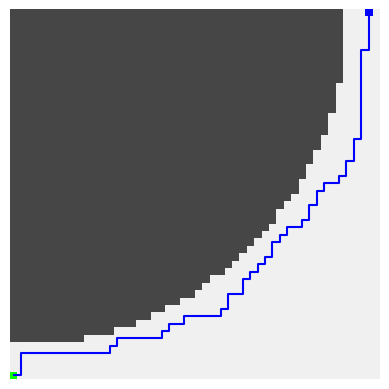

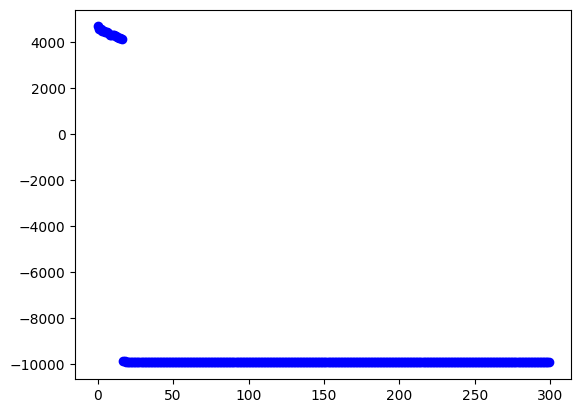

In [179]:
class Indiv():
    def __init__(self, actions=[], sc=None):
        self.actions = actions
        self.score = sc

def continue_indiv(indiv, show=False, wt=0.01):
    score = 0
    indiv.score = 0
    env.reset()
    trajectory = [env.car]

    sum_diff_dist = 0
    running = True
    step = 0
    while running:
        d1 = env.car.dist(env.track.end)
        # Choice of next action
        else_cond = True
        if step >= len(indiv.actions):
            indiv.actions.append(None)

        if indiv.actions[step]!=None:
            action = indiv.actions[step]
            if action not in env.possible_action(env.car):
                indiv.actions[step] = None

        if indiv.actions[step] == None:
            possible_choices = env.possible_action(env.car)
            if step > 0:
                id = -1
                if step < len(indiv.actions):
                    id = step-1
                op_act = env.get_opposite_action(indiv.actions[id])
                if op_act in possible_choices:
                    possible_choices.remove(op_act)
                if possible_choices != []:
                    action = rd.choice(possible_choices)
                else:
                    action = env.get_opposite_action(indiv.actions[-1])
            else:
                action = rd.choices(possible_choices)[0]
            
            if step < len(indiv.actions):
                indiv.actions[step] = action
            else:
                indiv.actions.append(action)

        # Simulation
        obs, reward, done, infos = env.step(action)
        score += reward
        trajectory.append(env.car)

        # Render the game
        if show:
            env.render(waiting_time=wt, trajectory=trajectory)
        if done == True:
            running = False

        step += 1

        var = 0

        if infos[0]:
            var += -2000
        if infos[1]:
            var += 4000

        d2 = env.car.dist(env.track.end)
        sum_diff_dist *= 0.95
        sum_diff_dist += d2 - d1

    indiv.score += var + env.car.dist(env.track.end)*10 + step + sum_diff_dist
    return indiv


def gen_indiv():
    return continue_indiv(Indiv())

def gen_pop():
    return [gen_indiv() for i in range(LEN_POP)]

def mutate_indiv(indiv: Indiv):    
    i1 = copy_indiv(indiv)
    for i in range(2):
        if i1.actions != []:
            del i1.actions[-1]

    i2 = copy_indiv(indiv)
    nb_none = rd.randint(1, max(int(len(i2.actions)/3),1))
    x = rd.randint(0, max(len(i2.actions)-1 - nb_none,0))
    for i in range(nb_none):
        i2.actions[x+i] = None
    for i in range(nb_none):
        if i2.actions != []:
            del i2.actions[-1]
    
    i3 = copy_indiv(indiv)
    nb_none = rd.randint(1, 10)
    x = rd.randint(0, max(len(i3.actions)-3, 0))
    for i in range(nb_none):
        if i3.actions != [] and x < len(i3.actions):
            del i3.actions[x]
    for i in range(2):
        if i3.actions != []:
            del i3.actions[-1]
    y = rd.randint(0, max(len(i3.actions)-1,0))
    i3.actions = i3.actions[y:] + [None for _ in range(nb_none)] + i3.actions[:y]

    #return [i1, i2, i3]
    return [continue_indiv(i1), continue_indiv(i2), continue_indiv(i3)]

def cross_over(indiv1, indiv2):
    #TODO
    return copy_indiv(indiv1)

def sort_pop(pop):
    pop.sort( key = lambda x: x.score)

def copy_indiv(indiv: Indiv):
    return Indiv([x for x in indiv.actions], indiv.score)

def select_pop(pop):
    new_pop = []
    pourcentage = 0
    k = int( (1 + np.sqrt(1 + 8*pourcentage*LEN_POP)) / 2 ) 

    for i in range( int(0.2*LEN_POP) ):
        new_pop.append(pop[i])
        
    for i in range(k):
        for j in range(i+1, k):
            new_pop.append(cross_over(pop[i], pop[j]))
    
    for i in range(int(LEN_POP*0.2)):
        new_indiv = mutate_indiv(pop[i])
        for id in new_indiv:
            new_pop.append(id)

    while (len(new_pop) != LEN_POP):
        new_pop.append(gen_indiv())

    return new_pop


LEN_POP = 400
def algo_gen():
    NB_GEN = 300
    pop = gen_pop()
    score_liste = []
    for gen in range(NB_GEN):
        sort_pop(pop)
        pop = select_pop(pop)

        if gen % 10 == 0:
            print(gen, end=" ")
        if (gen+1) % 10 == 0:
            print(pop[0].actions)
            continue_indiv(pop[0], show=True, wt=0.01)
        score_liste.append(pop[0].score)
    
    for gen,sc in enumerate(score_liste):
        plt.plot(gen, sc, '-o', color='blue', markersize=2)
    plt.show()
    return pop[0]

        
best = algo_gen()

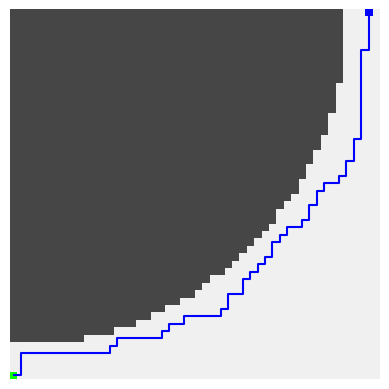

In [180]:
#best = Indiv([0,0,0,0,0,0,0,0,0])
continue_indiv(best, show=True, wt=0.001)
env.close()